# Experiment analysis

In [76]:
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 13)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
%matplotlib inline

In [103]:
df = pd.read_table('results.tsv', sep='\t')
print("Successful: {}\nFailed: {}".format(len(df[df['result.success'] == True]), len(df[df['result.success'] == False])))

Successful: 762
Failed: 0


In [106]:
df[-5:][['model.optimizer', 'result.timestamp', 'result.test_acc', 'result.running_time']]

,model.optimizer,result.timestamp,result.test_acc,result.running_time
757,rmsprop,2016-12-03 04:42:02.647452,0.980083,0 days 00:06:45.157307
758,rmsprop,2016-12-03 04:49:17.063119,0.978583,0 days 00:01:48.814142
759,rmsprop,2016-12-03 04:51:33.885317,0.980083,0 days 00:07:37.258082
760,rmsprop,2016-12-03 04:59:41.202131,0.978167,0 days 00:01:49.003291
761,rmsprop,2016-12-03 05:01:59.111539,0.980000,0 days 00:08:26.683645


In [79]:
#df.sort_values('result.test_acc').tail()[['result.test_acc', 'model.layers'] + feat_uniq_col]

# Filtering not so useful experiments

* failed experiments
* experiments with less than 30000 samples-per-class

In [80]:
orig = len(df)
df = df[(df['result.success'] == True) & (df['feat.sample_per_class'] >= 30000)]
print("Filtering experiments: {} --> {}".format(orig, len(df)))

Filtering experiments: 702 --> 498


In [81]:
def get_varying_columns(df, prefix=None):
    out_cols = []
    filtered_cols = df.columns
    if prefix is not None:
        filtered_cols = filter(lambda x: x.startswith(prefix), filtered_cols)
    for col in filtered_cols:
        if df[col].unique().shape[0] > 1:
            out_cols.append(col)
    return out_cols

def get_too_varying_columns(df, prefix=None, threshold=0.95):
    out_cols = []
    filtered_cols = df.columns
    if prefix is not None:
        filtered_cols = filter(lambda x: x.startswith(prefix), cols)
    for col in filtered_cols:
        uniq_vals = df[col].unique().shape[0]
        if uniq_vals > threshold * len(df):
            out_cols.append(col)
    return out_cols

In [82]:
feat_uniq_col = get_varying_columns(df, 'feat.')
result_uniq_col = get_varying_columns(df, 'result.')
model_uniq_col = get_varying_columns(df, 'model.')
all_params = feat_uniq_col + model_uniq_col
non_monoton = get_varying_columns(df)
uninteresting_columns = filter(lambda x: x not in non_monoton, df.columns)
ignore_cols = [
    'result.train_loss', 'result.test_loss', 'result.timestamp', 'result.running_time',
]
result_uniq_col = [col for col in result_uniq_col if col not in ignore_cols]
interesting_columns = result_uniq_col + feat_uniq_col + model_uniq_col

In [83]:
df[['result.test_acc'] + all_params].sort_values('result.test_acc', ascending=False).to_csv('results_filtered_columns.tsv', sep='\t')

## Unique feature combinations

In [84]:
df[feat_uniq_col].drop_duplicates()

,feat.last_char,feat.use_padding,feat.include_smaller_ngrams,feat.N
204,6.0,True,False,1.0
336,6.0,False,False,6.0
402,6.0,True,False,2.0
432,6.0,True,True,2.0
472,3.0,True,True,1.0
473,3.0,True,True,2.0
474,3.0,True,True,3.0
475,4.0,True,True,1.0
476,4.0,True,True,2.0
477,4.0,True,True,3.0


### Number of experiments per combination

In [85]:
df.groupby(feat_uniq_col).count()['model.nb_epoch'].to_frame()

model.nb_epoch
feat.last_char feat.use_padding feat.include_smaller_ngrams feat.N                
3.0            True             True                        1.0                  1
                                                            2.0                  1
                                                            3.0                  1
4.0            True             True                        1.0                  1
                                                            2.0                  1
                                                            3.0                  1
5.0            True             True                        1.0                  1
                                                            2.0                  1
                                                            3.0                  1
6.0            False            False                       6.0                 66
               True             False                       1.0                132
                                                            2.0                 30
                                True                        1.0                  1
                                                            2.0                249
                                                            3.0                  1
7.0            True             True                        1.0                  1
                                                            2.0                  1
                                                            3.0                  1
8.0            True             True                        1.0                  1
                                                            2.0                  1
                                                            3.0                  1
9.0            True             True                        1.0                  1
                                                            2.0                  1
                                                            3.0                  2

## Maximum test accuracy by feature combination

,result.test_acc,feat.last_char,feat.use_padding,feat.include_smaller_ngrams,feat.N
472,0.935833,3.0,True,True,1.0
473,0.930333,3.0,True,True,2.0
474,0.936000,3.0,True,True,3.0
475,0.966000,4.0,True,True,1.0
476,0.971833,4.0,True,True,2.0
477,0.972833,4.0,True,True,3.0
478,0.973250,5.0,True,True,1.0
479,0.980000,5.0,True,True,2.0
480,0.980083,5.0,True,True,3.0
359,0.819917,6.0,False,False,6.0


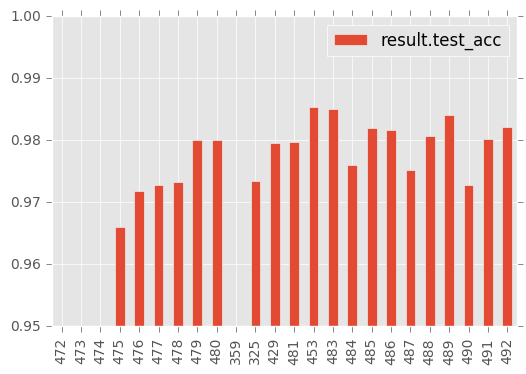

In [86]:
max_rows = df.loc[df.groupby(feat_uniq_col).idxmax()['result.test_acc'].astype(int)]
max_rows.plot(y='result.test_acc', kind='bar', ylim=(0.95, 1))
max_rows[['result.test_acc'] + feat_uniq_col]

# The absolute best combination

In [107]:
best = df.loc[df['result.test_acc'].idxmax()].to_frame().sort_index()
best

,453
feat.N,2
feat.data_path,/mnt/store/hlt/Language/Hungarian/Crawl/Web2/a...
feat.encoding,latin2
feat.include_smaller_ngrams,True
feat.last_char,6
feat.sample_per_class,30000
feat.tag_filter,"('NOUN', 'VERB')"
feat.use_padding,True
global.comment,include smaller ngrams - first experiments
global.nolog,False


In [88]:
def find_same_rows(df, lhs, include):
    filt = df
    for col in df.columns:
        if col in include:
            filt = filt[filt[col] == lhs[col].values[0]]
    return filt

In [89]:
filt = find_same_rows(df, best.transpose(), all_params)['result.test_acc']
filt

453    0.985333
482    0.983833
527    0.981833
701    0.978833
Name: result.test_acc, dtype: float64

# Extract NN depth

In [90]:
df['model.depth'] = df['model.layers'].apply(lambda x: len(eval(x)))
df[['model.depth', 'result.test_acc']].groupby('model.depth').describe()

result.test_acc
model.depth                       
1           count        20.000000
            mean          0.980937
            std           0.001876
            min           0.977500
            25%           0.979438
            50%           0.981042
            75%           0.982333
            max           0.985083
2           count       454.000000
            mean          0.867838
            std           0.194320
            min           0.007333
            25%           0.820250
            50%           0.960792
            75%           0.979229
            max           0.985333
3           count        24.000000
            mean          0.980271
            std           0.002118
            min           0.976500
            25%           0.979000
            50%           0.980625
            75%           0.981708
            max           0.984000

In [91]:
df.groupby('model.depth').describe()

feat.N  feat.last_char  feat.sample_per_class  \
model.depth                                                            
1           count   20.000000       20.000000                   20.0   
            mean     2.000000        6.000000                30000.0   
            std      0.000000        0.000000                    0.0   
            min      2.000000        6.000000                30000.0   
            25%      2.000000        6.000000                30000.0   
            50%      2.000000        6.000000                30000.0   
            75%      2.000000        6.000000                30000.0   
            max      2.000000        6.000000                30000.0   
2           count  454.000000      454.000000                  454.0   
            mean     2.292952        6.006608                30000.0   
            std      1.603003        0.453050                    0.0   
            min      1.000000        3.000000                30000.0   
            25%      1.000000        6.000000                30000.0   
            50%      2.000000        6.000000                30000.0   
            75%      2.000000        6.000000                30000.0   
            max      6.000000        9.000000                30000.0   
3           count   24.000000       24.000000                   24.0   
            mean     2.000000        6.000000                30000.0   
            std      0.000000        0.000000                    0.0   
            min      2.000000        6.000000                30000.0   
            25%      2.000000        6.000000                30000.0   
            50%      2.000000        6.000000                30000.0   
            75%      2.000000        6.000000                30000.0   
            max      2.000000        6.000000                30000.0   

                   global.train_test_split  model.batch_size  model.input_dim  \
model.depth                                                                     
1           count             2.000000e+01         20.000000        20.000000   
            mean              9.000000e-01        500.000000      5510.000000   
            std               2.278130e-16          0.000000         0.000000   
            min               9.000000e-01        500.000000      5510.000000   
            25%               9.000000e-01        500.000000      5510.000000   
            50%               9.000000e-01        500.000000      5510.000000   
            75%               9.000000e-01        500.000000      5510.000000   
            max               9.000000e-01        500.000000      5510.000000   
2           count             4.540000e+02        454.000000       454.000000   
            mean              9.000000e-01        923.953744      5524.246696   
            std               3.334343e-16       1627.863840      5240.612819   
            min               9.000000e-01         10.000000       250.000000   
            25%               9.000000e-01        200.000000       481.000000   
            50%               9.000000e-01        500.000000      5510.000000   
            75%               9.000000e-01        500.000000      5510.000000   
            max               9.000000e-01      10000.000000     38028.000000   
3           count             2.400000e+01         24.000000        24.000000   
            mean              9.000000e-01        500.000000      5510.000000   
            std               0.000000e+00          0.000000         0.000000   
            min               9.000000e-01        500.000000      5510.000000   
            25%               9.000000e-01        500.000000      5510.000000   
            50%               9.000000e-01        500.000000      5510.000000   
            75%               9.000000e-01        500.000000      5510.000000   
            max               9.000000e-01        500.000000      5510.000000   

                   model.nb_epoch  model.ou

In [92]:
draw = False

if draw:
    f = df[df['feat.sample_per_class'] > 10000]
    batches = df['model.batch_size'].unique()

    for key, val in f.groupby(features):
        for nb in batches:
            filt = val[val['model.batch_size'] == nb]
            if len(filt) == 0:
                continue
            if filt['result.test_acc'].max() < 0.95:
                continue
            filt = filt.groupby('model.nb_epoch').mean()
            filt[filt['model.batch_size'] == nb].plot(y='result.test_acc', kind='bar',
                                                    ylim=(.9, 1), title="Epoch: {}, last_char: {} Sample: {} N: {}".format(
                    nb, key[0], key[5], key[-1]))